In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import utils as u
import importlib
importlib.reload(u)
import pandas as pd
from collections import Counter
from IPython.display import display, Markdown, Latex
import os
import glob

In [3]:
# Warning : metric_res is a global variable, run the following cells only once
metrics_res = {}
metrics_res["all"] = [[], [], [], []]
metrics_res["mops"] = [[], [], [], []]

In [4]:
# Load the mpc database
mpc_orb = pd.read_parquet("../data/MPC_Database/mpcorb_extended.parquet",
    columns=["Number", "Name", "Principal_desig", "Other_desigs", "a", "e", "i", "Node", "Peri", "M", "Epoch", "Orbit_type"])

# Reconstruction performance analysis

##### Common parameters

Associations
* intra_night_separation=145 arcsecond
* intra_night_magdiff_limit_same_fid=0.2
* intra_night_magdiff_limit_diff_fid=0.8
* inter_night_separation=0.3 degree/day
* inter_night_magdiff_limit_same_fid=0.1
* inter_night_magdiff_limit_diff_fid=0.5
* maximum_angle=1 degree/day

Orbit fitting
* n_triplets=30
* noise_ntrials=20
* prop_epoch=None
* orbfit_verbose=3

##### Definition
* Purity : Percentage of trajectory where all the observations belong the same object
* Efficiency : Number of trajectory reconstructed from the initial dataset (in percentage)

## 15_2_2

#### All associations

In [6]:
reconstructed_orbit, reconstructed_trajectory, input_data = u.get_tw_exp("15_2_2", "all")
print("Input data : {}".format(len(input_data)))
res = u.results(reconstructed_orbit, reconstructed_trajectory, input_data)
for i in range(0, 4):
    metrics_res["all"][i].append(res[i+1])
Markdown(res[0])

Input data : 796486



|                     | Fink_FAT |                 |
|---------------------|----------|-----------------|
|                     | All      | Only with error |
| Confirmed SSO input | 87076       | X               |
| Detectable          | 43919       | X               |
| Reconstructed orbit | 39628    | 13252           |
| - Pure              | 28719    | 12853           |
| - Unique            | 19956    | 10755           |
| Purity              | 72.5 %   | 97.0 %          |
| Efficiency          | 45.4 %   | 24.5 %          |
        

In [8]:
Markdown(u.print_time_stats(u.get_stats("15_2_2", "all").T, u.path_tw))


|      |API time|Association time|Orbfit time|Trajectory volume|Total|
|------|-------------|--------------------|---------------|---------------------|---------|
| min (sec)  |    2.87     |        8.51        |     34.87 (7 trajectories)      |         7        | X |
|median (sec)|    20.34     |        76.77        |     291.52      |         3543        | X |
|max (sec)   |    89.69     |        261.56        |     744.13 (10334 trajectories)      |         10334        | X |
|total (hh:mm:ss) |    0:10:03.804098     |        0:39:37.054178        |     1:58:30.593144      |         X        |         2:48:11.451420        |
    

##### Observational window effect

In [11]:
res_gb_obs_tw = reconstructed_trajectory.sort_values("jd").groupby("ssoCandId").agg(obs_win=("jd", lambda x: list(x)[-1] - list(x)[0])).sort_values("obs_win")
Markdown("""
| |Observation window (days)|
|-|-------------------|
|min| {:0.3f}            |
|median|{:0.3f}          |
|max|{:0.3f}             |
""".format(res_gb_obs_tw.min().values[0], int(res_gb_obs_tw.median().values[0]), res_gb_obs_tw.max().values[0]))


| |Observation window (days)|
|-|-------------------|
|min| 0.017            |
|median|4.000          |
|max|25.047             |


#### Mops

In [14]:
reconstructed_mops_orbit, reconstructed_mops_trajectory, input_data = u.get_tw_exp("15_2_2", "mops")
print("Input data : {}".format(len(input_data)))
res = u.results(reconstructed_mops_orbit, reconstructed_mops_trajectory, input_data)
for i in range(0, 4):
    metrics_res["mops"][i].append(res[i+1])
Markdown(res[0])

Input data : 796486



|                     | Fink_FAT |                 |
|---------------------|----------|-----------------|
|                     | All      | Only with error |
| Confirmed SSO input | 87076       | X               |
| Detectable          | 43919       | X               |
| Reconstructed orbit | 26162    | 6065           |
| - Pure              | 17152    | 5598           |
| - Unique            | 13388    | 5200           |
| Purity              | 65.6 %   | 92.3 %          |
| Efficiency          | 30.5 %   | 11.8 %          |
        

In [15]:
Markdown(u.print_time_stats(u.get_stats("15_2_2", "mops").T, u.path_tw))


|      |API time|Association time|Orbfit time|Trajectory volume|Total|
|------|-------------|--------------------|---------------|---------------------|---------|
| min (sec)  |    2.87     |        4.24        |     55.28 (7 trajectories)      |         7        | X |
|median (sec)|    20.34     |        48.81        |     160.22      |         1623        | X |
|max (sec)   |    89.69     |        226.09        |     420.33 (5683 trajectories)      |         5683        | X |
|total (hh:mm:ss) |    0:10:03.804098     |        0:30:59.452998        |     1:17:36.919220      |         X        |         1:58:40.176316        |
    

##### Observational window effect

In [16]:
res_gb_obs_tw = reconstructed_mops_trajectory.sort_values("jd").groupby("ssoCandId").agg(obs_win=("jd", lambda x: list(x)[-1] - list(x)[0])).sort_values("obs_win")
Markdown("""
| |Observation window (days)|
|-|-------------------|
|min| {:0.3f}            |
|median|{:0.3f}          |
|max|{:0.3f}             |
""".format(res_gb_obs_tw.min().values[0], int(res_gb_obs_tw.median().values[0]), res_gb_obs_tw.max().values[0]))


| |Observation window (days)|
|-|-------------------|
|min| 0.017            |
|median|4.000          |
|max|28.921             |


#### Comparison with MPC

In [18]:
mpc_table_res = u.generate_mpc_results(
    mpc_orb, 
    input_data, 
    reconstructed_orbit, 
    reconstructed_trajectory, 
    reconstructed_mops_orbit, 
    reconstructed_mops_trajectory
)

display(Markdown(mpc_table_res))


|  | Initial orbit Distribution | Fink_FAT | MOPS |
|--|----------------------------|----------|------|
| Amor | 51 | 2 (3.92 %) | 0 (nan %) |
| Apollo | 48 | 1 (2.08 %) | 0 (nan %) |
| Aten | 5 | 0 (nan %) | 0 (nan %) |
| Distant Object | 11 | 0 (nan %) | 0 (nan %) |
| Hilda | 183 | 33 (18.03 %) | 16 (8.74 %) |
| Hungaria | 751 | 62 (8.26 %) | 40 (5.33 %) |
| Jupiter Trojan | 1040 | 198 (19.04 %) | 75 (7.21 %) |
| MBA | 40538 | 10233 (25.24 %) | 4955 (12.22 %) |
| Object with perihelion distance < 1.665 AU | 391 | 45 (11.51 %) | 28 (7.16 %) |
| Phocaea | 585 | 151 (25.81 %) | 76 (12.99 %) |


#### RMS comparison

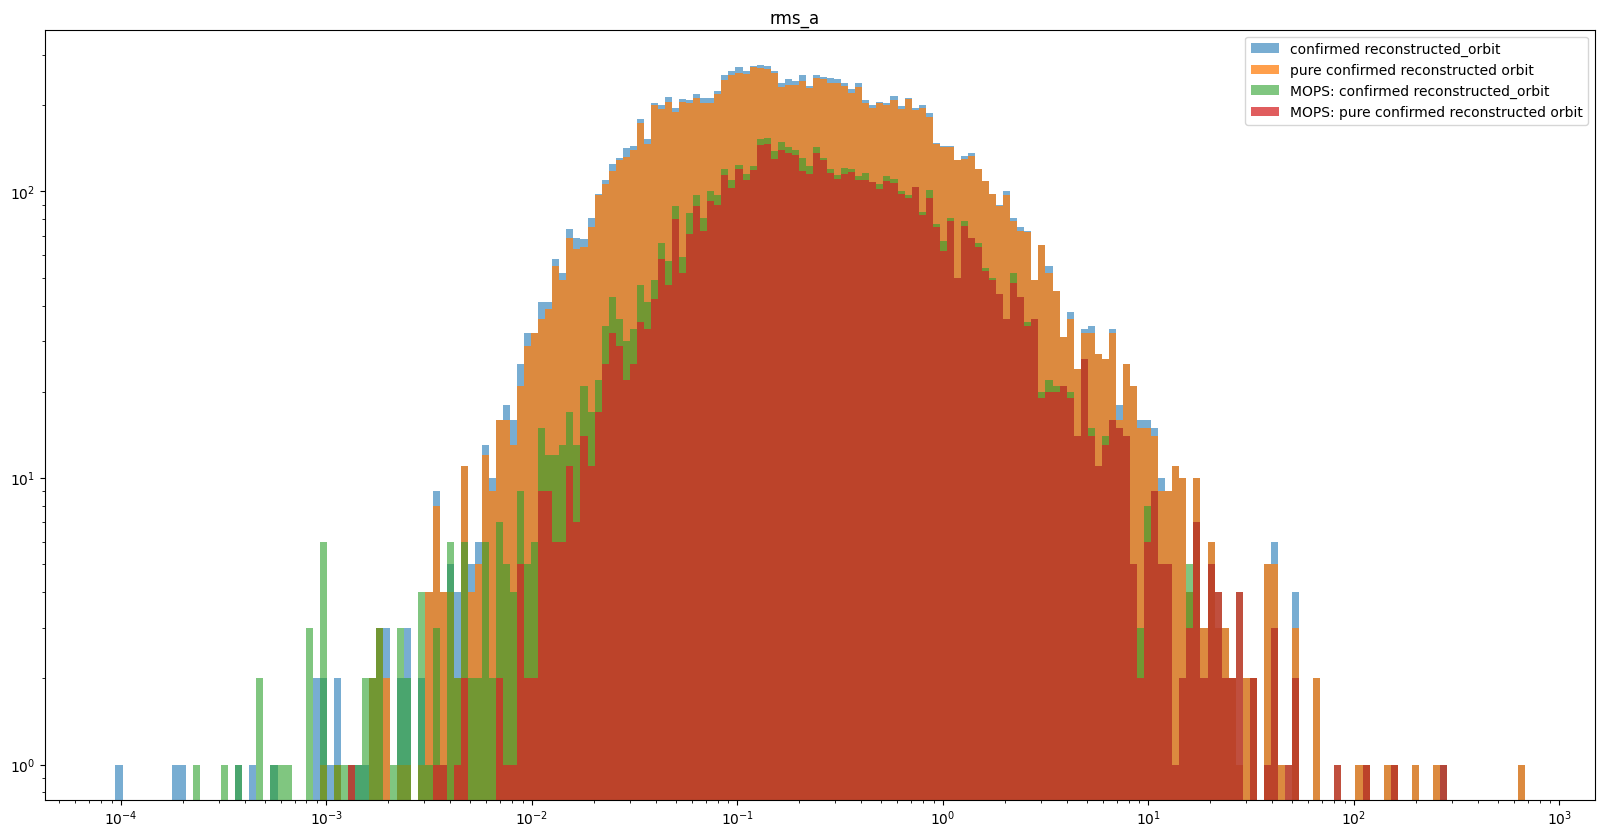

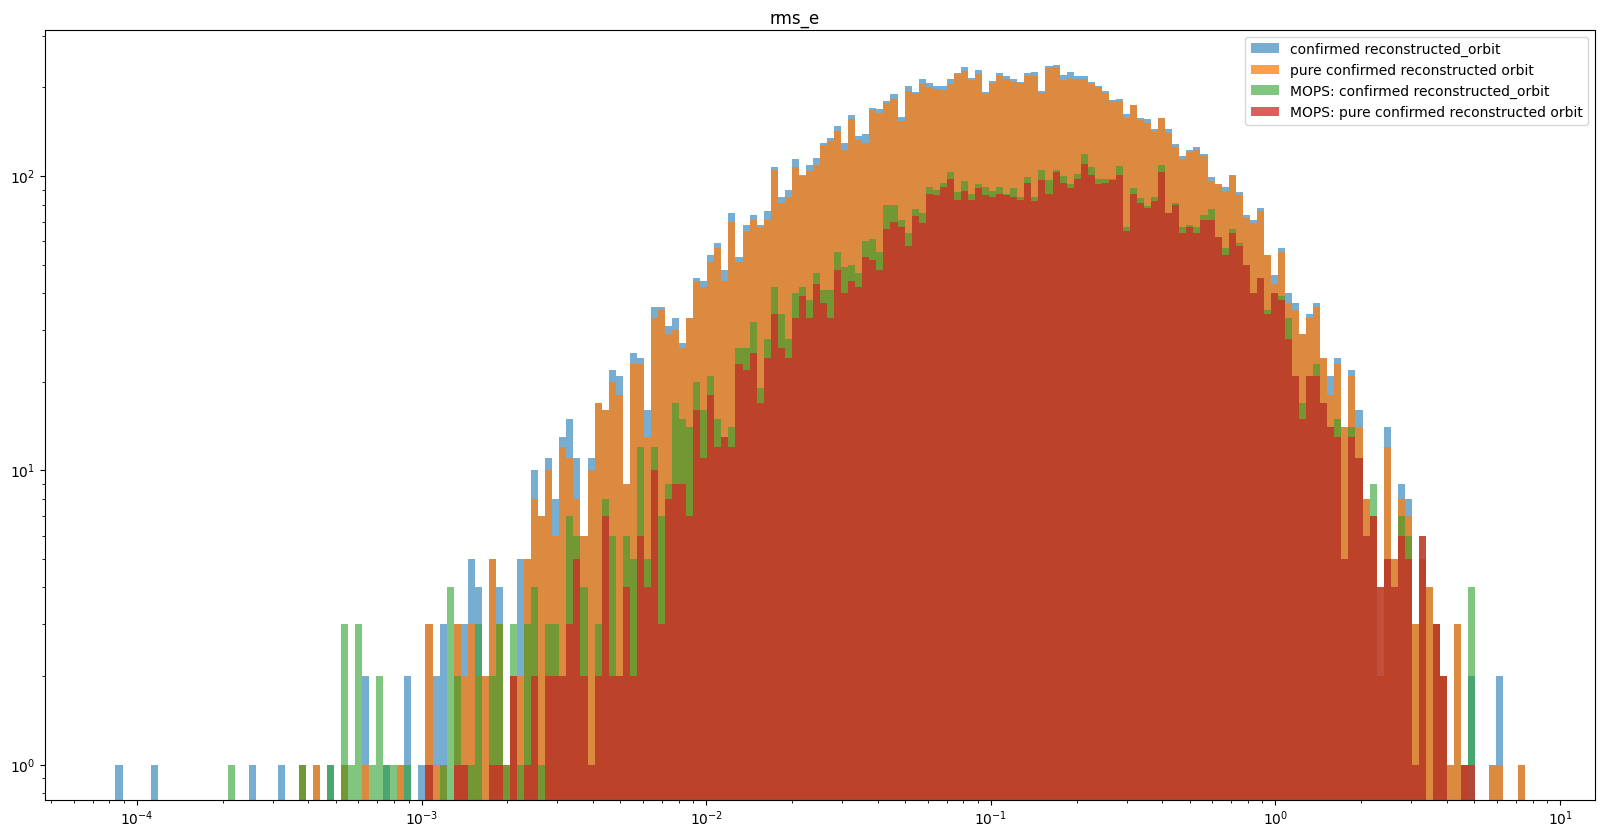

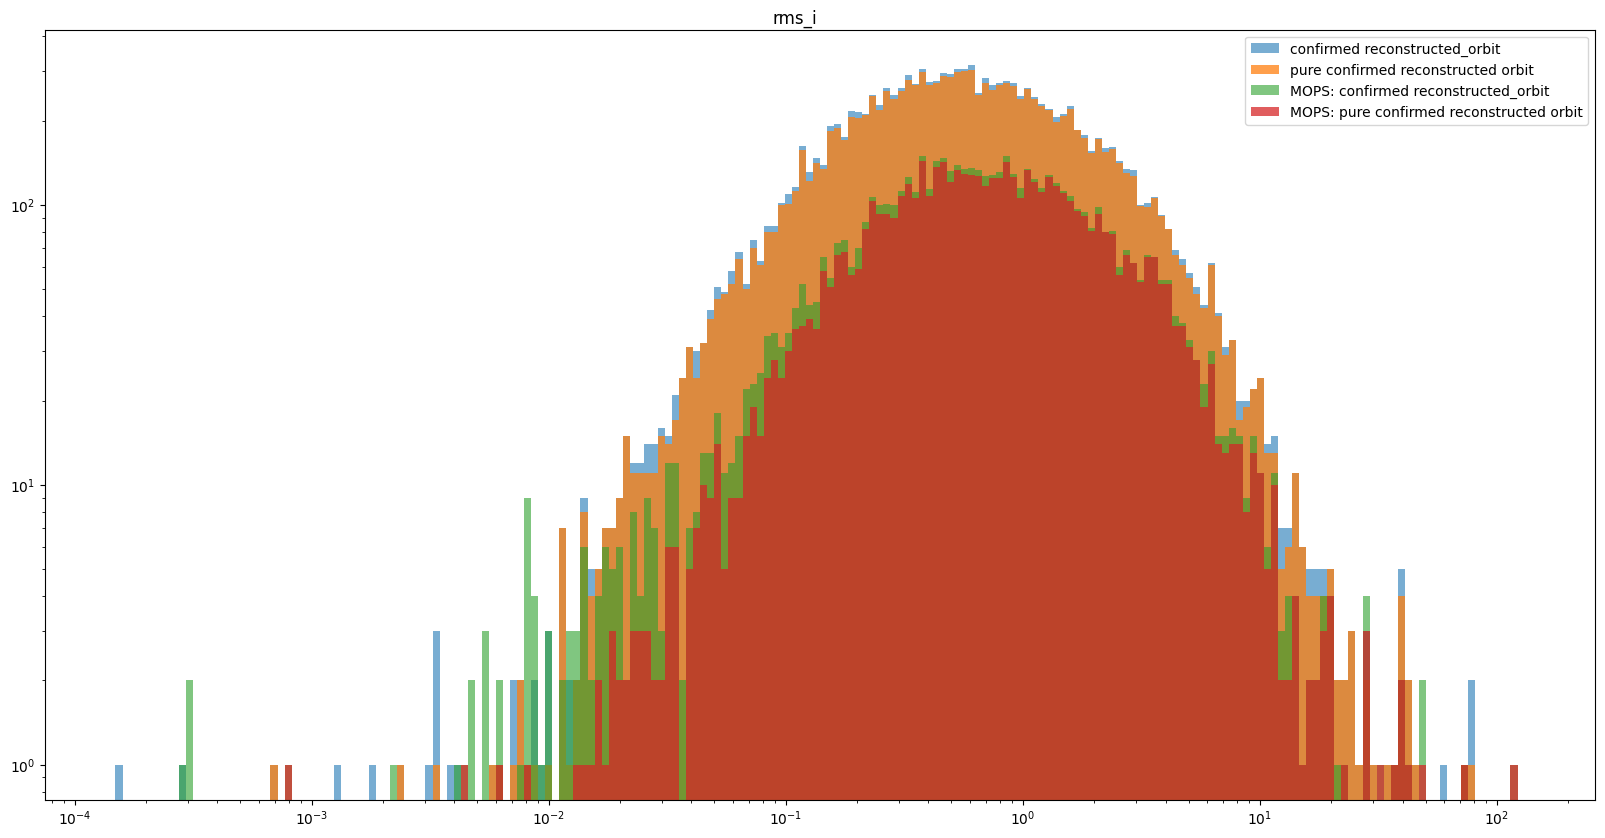

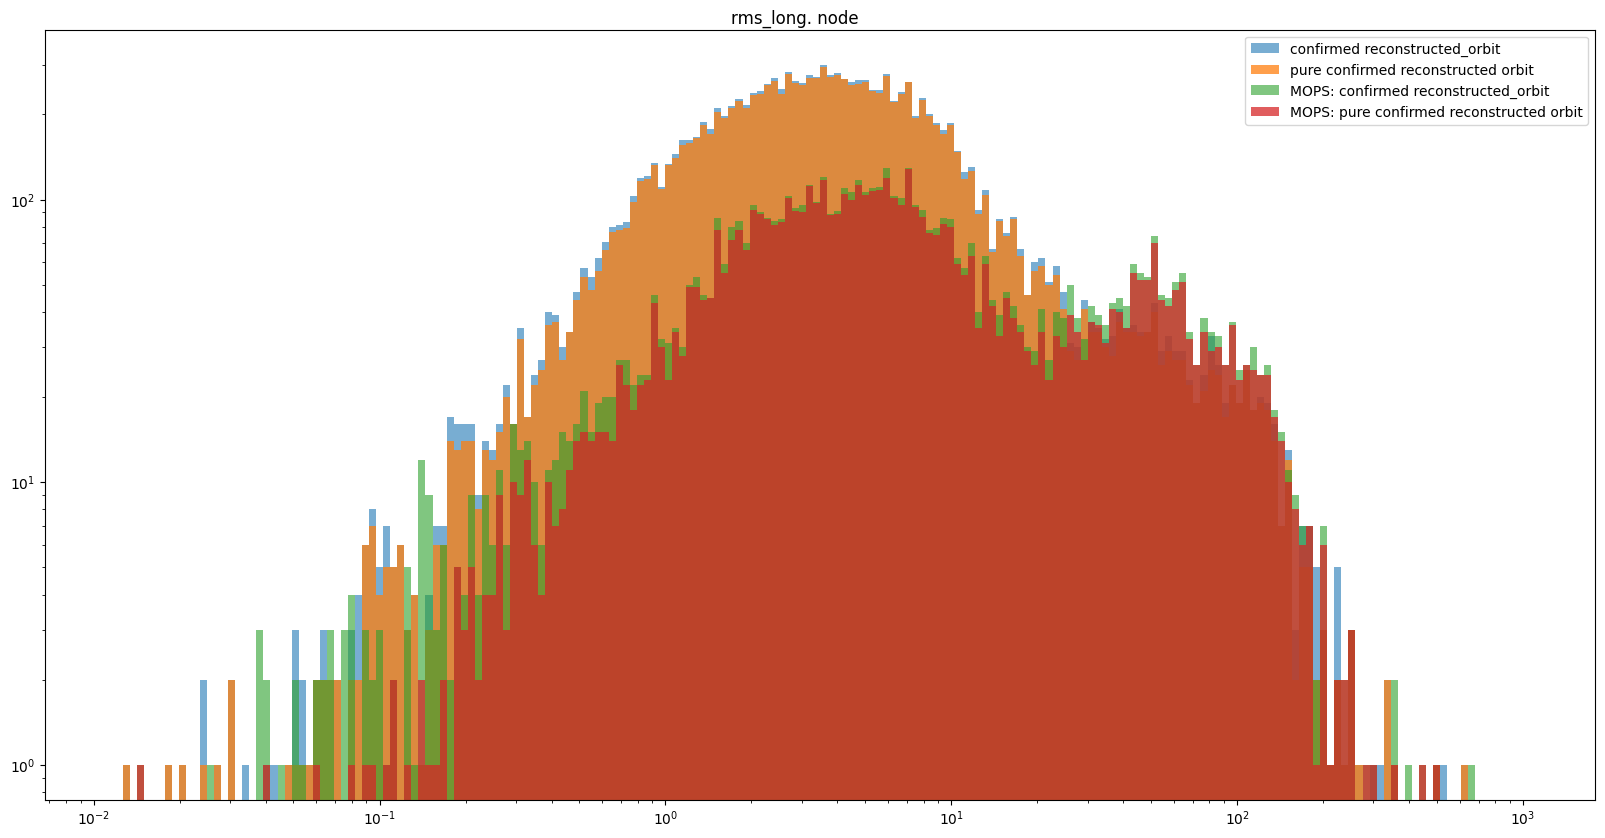

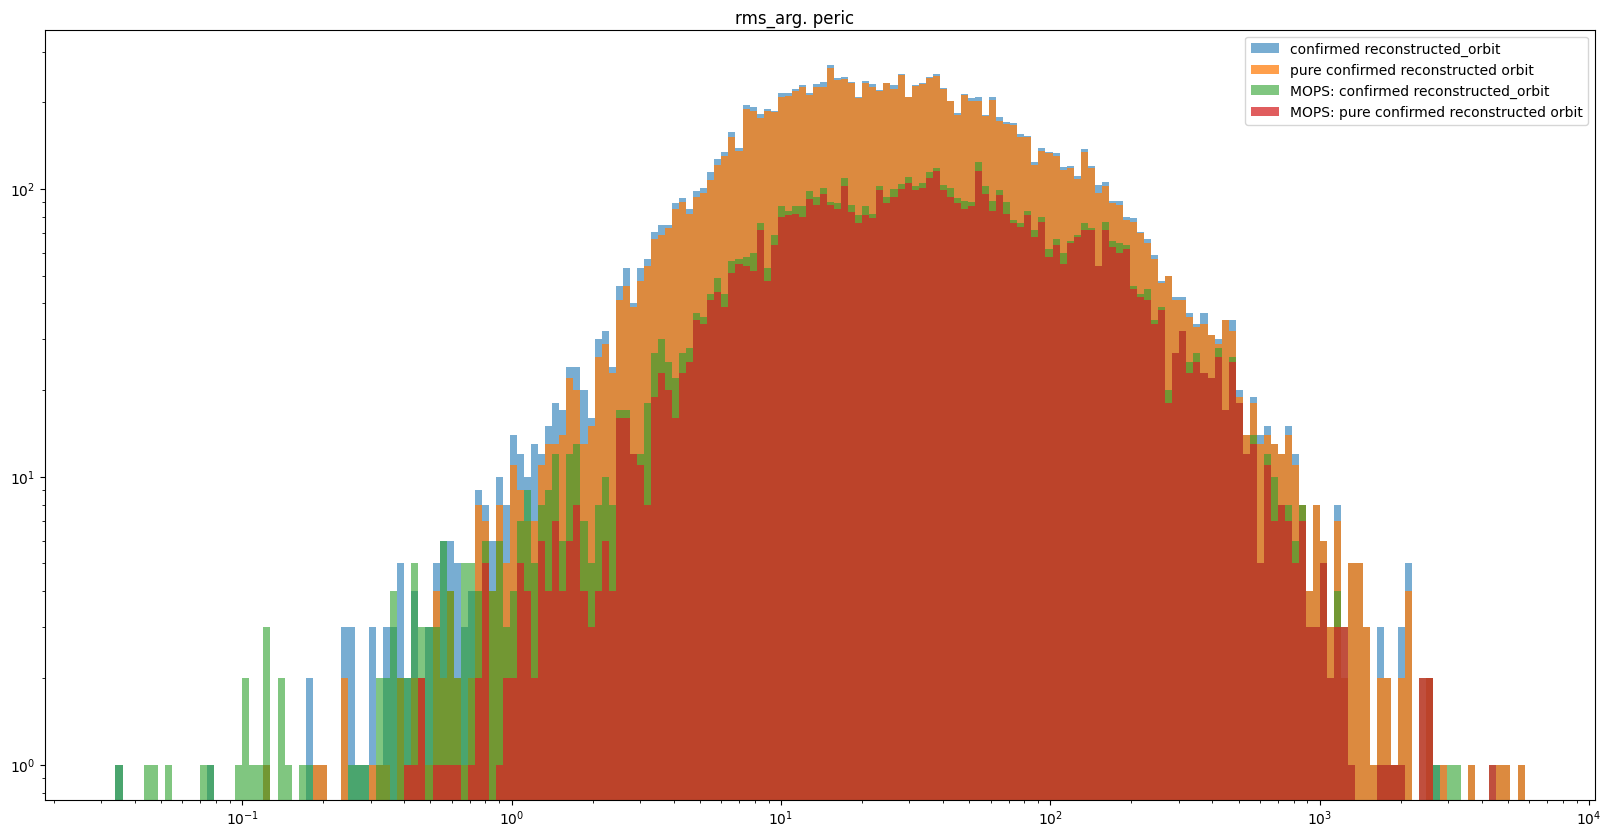

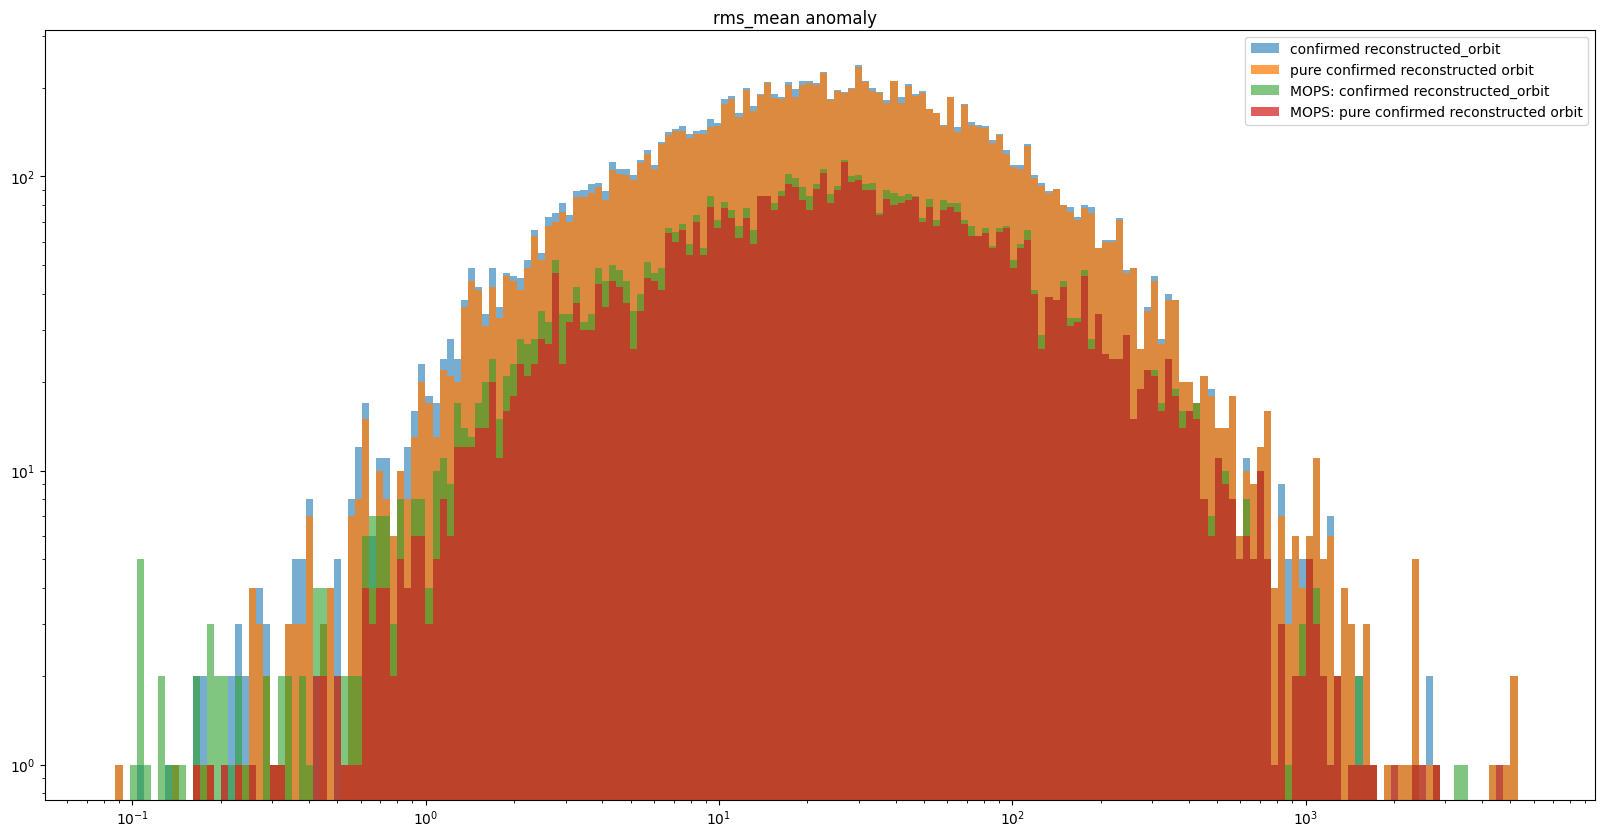

In [19]:
u.plot_rms_distribution(reconstructed_orbit, reconstructed_trajectory, reconstructed_mops_orbit, reconstructed_mops_trajectory)

## 15_2_15

#### All associations

In [21]:
reconstructed_orbit, reconstructed_trajectory, input_data = u.get_tw_exp("15_2_15", "all")
print("Input data : {}".format(len(input_data)))
res = u.results(reconstructed_orbit, reconstructed_trajectory, input_data)
for i in range(0, 4):
    metrics_res["all"][i].append(res[i+1])
Markdown(res[0])

Input data : 796486



|                     | Fink_FAT |                 |
|---------------------|----------|-----------------|
|                     | All      | Only with error |
| Confirmed SSO input | 87076       | X               |
| Detectable          | 43919       | X               |
| Reconstructed orbit | 32460    | 11246           |
| - Pure              | 22226    | 10787           |
| - Unique            | 16568    | 9131           |
| Purity              | 68.5 %   | 95.9 %          |
| Efficiency          | 37.7 %   | 20.8 %          |
        

In [22]:
Markdown(u.print_time_stats(u.get_stats("15_2_15", "all").T, u.path_tw))


|      |API time|Association time|Orbfit time|Trajectory volume|Total|
|------|-------------|--------------------|---------------|---------------------|---------|
| min (sec)  |    2.87     |        8.95        |     34.78 (7 trajectories)      |         7        | X |
|median (sec)|    20.34     |        106.97        |     591.59      |         7964        | X |
|max (sec)   |    89.69     |        329.79        |     1465.78 (21242 trajectories)      |         21242        | X |
|total (hh:mm:ss) |    0:10:03.804098     |        0:51:35.689147        |     4:28:15.060581      |         X        |         5:29:54.553827        |
    

#### Mops

In [23]:
reconstructed_mops_orbit, reconstructed_mops_trajectory, input_data = u.get_tw_exp("15_2_15", "mops")
print("Input data : {}".format(len(input_data)))
res = u.results(reconstructed_mops_orbit, reconstructed_mops_trajectory, input_data)
for i in range(0, 4):
    metrics_res["mops"][i].append(res[i+1])
Markdown(res[0])

Input data : 796486



|                     | Fink_FAT |                 |
|---------------------|----------|-----------------|
|                     | All      | Only with error |
| Confirmed SSO input | 87076       | X               |
| Detectable          | 43919       | X               |
| Reconstructed orbit | 29192    | 7680           |
| - Pure              | 17354    | 6957           |
| - Unique            | 13963    | 6457           |
| Purity              | 59.4 %   | 90.6 %          |
| Efficiency          | 31.8 %   | 14.7 %          |
        

In [24]:
Markdown(u.print_time_stats(u.get_stats("15_2_15", "mops").T, u.path_tw))


|      |API time|Association time|Orbfit time|Trajectory volume|Total|
|------|-------------|--------------------|---------------|---------------------|---------|
| min (sec)  |    2.87     |        4.74        |     33.51 (7 trajectories)      |         7        | X |
|median (sec)|    20.34     |        58.65        |     272.77      |         3296        | X |
|max (sec)   |    89.69     |        258.85        |     970.67 (13833 trajectories)      |         13833        | X |
|total (hh:mm:ss) |    0:10:03.804098     |        0:35:51.016684        |     2:15:45.523958      |         X        |         3:01:40.344740        |
    

#### Comparison with MPC

In [25]:
mpc_table_res = u.generate_mpc_results(
    mpc_orb, 
    input_data, 
    reconstructed_orbit, 
    reconstructed_trajectory, 
    reconstructed_mops_orbit, 
    reconstructed_mops_trajectory
)

display(Markdown(mpc_table_res))


|  | Initial orbit Distribution | Fink_FAT | MOPS |
|--|----------------------------|----------|------|
| Amor | 51 | 1 (1.96 %) | 3 (5.88 %) |
| Apollo | 48 | 0 (nan %) | 1 (2.08 %) |
| Aten | 5 | 0 (nan %) | 0 (nan %) |
| Distant Object | 11 | 0 (nan %) | 0 (nan %) |
| Hilda | 183 | 32 (17.49 %) | 26 (14.21 %) |
| Hungaria | 751 | 75 (9.99 %) | 52 (6.92 %) |
| Jupiter Trojan | 1040 | 200 (19.23 %) | 121 (11.63 %) |
| MBA | 40538 | 8600 (21.21 %) | 6114 (15.08 %) |
| Object with perihelion distance < 1.665 AU | 391 | 48 (12.28 %) | 37 (9.46 %) |
| Phocaea | 585 | 150 (25.64 %) | 88 (15.04 %) |


## 15_15_2

#### All associations

In [27]:
reconstructed_orbit, reconstructed_trajectory, input_data = u.get_tw_exp("15_15_2", "all")
print("Input data : {}".format(len(input_data)))
res = u.results(reconstructed_orbit, reconstructed_trajectory, input_data)
for i in range(0, 4):
    metrics_res["all"][i].append(res[i+1])
Markdown(res[0])

Input data : 796486



|                     | Fink_FAT |                 |
|---------------------|----------|-----------------|
|                     | All      | Only with error |
| Confirmed SSO input | 87076       | X               |
| Detectable          | 43919       | X               |
| Reconstructed orbit | 35138    | 11379           |
| - Pure              | 24724    | 10968           |
| - Unique            | 17921    | 9346           |
| Purity              | 70.4 %   | 96.4 %          |
| Efficiency          | 40.8 %   | 21.3 %          |
        

In [28]:
Markdown(u.print_time_stats(u.get_stats("15_15_2", "all").T, u.path_tw))


|      |API time|Association time|Orbfit time|Trajectory volume|Total|
|------|-------------|--------------------|---------------|---------------------|---------|
| min (sec)  |    2.87     |        8.50        |     33.48 (7 trajectories)      |         7        | X |
|median (sec)|    20.34     |        92.48        |     459.63      |         5853        | X |
|max (sec)   |    89.69     |        293.88        |     1098.29 (14961 trajectories)      |         14961        | X |
|total (hh:mm:ss) |    0:10:03.804098     |        0:46:56.061717        |     3:18:57.436275      |         X        |         4:15:57.302090        |
    

#### Mops

In [29]:
reconstructed_mops_orbit, reconstructed_mops_trajectory, input_data = u.get_tw_exp("15_15_2", "mops")
print("Input data : {}".format(len(input_data)))
res = u.results(reconstructed_mops_orbit, reconstructed_mops_trajectory, input_data)
for i in range(0, 4):
    metrics_res["mops"][i].append(res[i+1])
Markdown(res[0])

Input data : 796486



|                     | Fink_FAT |                 |
|---------------------|----------|-----------------|
|                     | All      | Only with error |
| Confirmed SSO input | 87076       | X               |
| Detectable          | 43919       | X               |
| Reconstructed orbit | 26157    | 6063           |
| - Pure              | 17148    | 5596           |
| - Unique            | 13386    | 5199           |
| Purity              | 65.6 %   | 92.3 %          |
| Efficiency          | 30.5 %   | 11.8 %          |
        

In [30]:
Markdown(u.print_time_stats(u.get_stats("15_15_2", "mops").T, u.path_tw))


|      |API time|Association time|Orbfit time|Trajectory volume|Total|
|------|-------------|--------------------|---------------|---------------------|---------|
| min (sec)  |    2.87     |        4.63        |     38.90 (7 trajectories)      |         7        | X |
|median (sec)|    20.34     |        49.76        |     161.30      |         1623        | X |
|max (sec)   |    89.69     |        234.17        |     450.63 (5683 trajectories)      |         5683        | X |
|total (hh:mm:ss) |    0:10:03.804098     |        0:31:51.601722        |     1:17:11.709290      |         X        |         1:59:07.115111        |
    

#### Comparison with MPC

In [31]:
mpc_table_res = u.generate_mpc_results(
    mpc_orb, 
    input_data, 
    reconstructed_orbit, 
    reconstructed_trajectory, 
    reconstructed_mops_orbit, 
    reconstructed_mops_trajectory
)

display(Markdown(mpc_table_res))


|  | Initial orbit Distribution | Fink_FAT | MOPS |
|--|----------------------------|----------|------|
| Amor | 51 | 1 (1.96 %) | 0 (nan %) |
| Apollo | 48 | 1 (2.08 %) | 0 (nan %) |
| Aten | 5 | 0 (nan %) | 0 (nan %) |
| Distant Object | 11 | 0 (nan %) | 0 (nan %) |
| Hilda | 183 | 31 (16.94 %) | 16 (8.74 %) |
| Hungaria | 751 | 61 (8.12 %) | 40 (5.33 %) |
| Jupiter Trojan | 1040 | 178 (17.12 %) | 75 (7.21 %) |
| MBA | 40538 | 8869 (21.88 %) | 4954 (12.22 %) |
| Object with perihelion distance < 1.665 AU | 391 | 43 (11.00 %) | 28 (7.16 %) |
| Phocaea | 585 | 134 (22.91 %) | 76 (12.99 %) |


## 15_15_15

#### All associations

In [32]:
reconstructed_orbit, reconstructed_trajectory, input_data = u.get_tw_exp("15_15_15", "all")
print("Input data : {}".format(len(input_data)))
res = u.results(reconstructed_orbit, reconstructed_trajectory, input_data)
for i in range(0, 4):
    metrics_res["all"][i].append(res[i+1])
Markdown(res[0])

Input data : 796486



|                     | Fink_FAT |                 |
|---------------------|----------|-----------------|
|                     | All      | Only with error |
| Confirmed SSO input | 87076       | X               |
| Detectable          | 43919       | X               |
| Reconstructed orbit | 21960    | 6738           |
| - Pure              | 13714    | 6341           |
| - Unique            | 10697    | 5475           |
| Purity              | 62.4 %   | 94.1 %          |
| Efficiency          | 24.4 %   | 12.5 %          |
        

In [34]:
Markdown(u.print_time_stats(u.get_stats("15_15_15", "all").T, u.path_tw))


|      |API time|Association time|Orbfit time|Trajectory volume|Total|
|------|-------------|--------------------|---------------|---------------------|---------|
| min (sec)  |    2.87     |        9.36        |     32.81 (7 trajectories)      |         7        | X |
|median (sec)|    20.34     |        163.91        |     1127.04      |         16022        | X |
|max (sec)   |    89.69     |        577.25        |     4296.64 (63039 trajectories)      |         63039        | X |
|total (hh:mm:ss) |    0:10:03.804098     |        1:23:45.277509        |     10:17:53.782193      |         X        |         11:51:42.863800        |
    

#### Mops

In [35]:
reconstructed_mops_orbit, reconstructed_mops_trajectory, input_data = u.get_tw_exp("15_15_15", "mops")
print("Input data : {}".format(len(input_data)))
res = u.results(reconstructed_mops_orbit, reconstructed_mops_trajectory, input_data)
for i in range(0, 4):
    metrics_res["mops"][i].append(res[i+1])
Markdown(res[0])

Input data : 796486



|                     | Fink_FAT |                 |
|---------------------|----------|-----------------|
|                     | All      | Only with error |
| Confirmed SSO input | 87076       | X               |
| Detectable          | 43919       | X               |
| Reconstructed orbit | 29196    | 7682           |
| - Pure              | 17356    | 6959           |
| - Unique            | 13964    | 6459           |
| Purity              | 59.4 %   | 90.6 %          |
| Efficiency          | 31.8 %   | 14.7 %          |
        

In [36]:
Markdown(u.print_time_stats(u.get_stats("15_15_15", "mops").T, u.path_tw))


|      |API time|Association time|Orbfit time|Trajectory volume|Total|
|------|-------------|--------------------|---------------|---------------------|---------|
| min (sec)  |    2.87     |        4.77        |     34.31 (7 trajectories)      |         7        | X |
|median (sec)|    20.34     |        70.75        |     293.16      |         3296        | X |
|max (sec)   |    89.69     |        398.30        |     966.12 (13331 trajectories)      |         13833        | X |
|total (hh:mm:ss) |    0:10:03.804098     |        0:49:29.364980        |     2:16:39.571342      |         X        |         3:16:12.740419        |
    

#### Comparison with MPC

In [37]:
mpc_table_res = u.generate_mpc_results(
    mpc_orb, 
    input_data, 
    reconstructed_orbit, 
    reconstructed_trajectory, 
    reconstructed_mops_orbit, 
    reconstructed_mops_trajectory
)

display(Markdown(mpc_table_res))


|  | Initial orbit Distribution | Fink_FAT | MOPS |
|--|----------------------------|----------|------|
| Amor | 51 | 1 (1.96 %) | 3 (5.88 %) |
| Apollo | 48 | 0 (nan %) | 1 (2.08 %) |
| Aten | 5 | 0 (nan %) | 0 (nan %) |
| Distant Object | 11 | 0 (nan %) | 0 (nan %) |
| Hilda | 183 | 24 (13.11 %) | 26 (14.21 %) |
| Hungaria | 751 | 56 (7.46 %) | 52 (6.92 %) |
| Jupiter Trojan | 1040 | 108 (10.38 %) | 121 (11.63 %) |
| MBA | 40538 | 5116 (12.62 %) | 6116 (15.09 %) |
| Object with perihelion distance < 1.665 AU | 391 | 37 (9.46 %) | 37 (9.46 %) |
| Phocaea | 585 | 115 (19.66 %) | 88 (15.04 %) |


#### Summary

In [38]:
import matplotlib.pyplot as plt
import numpy as np

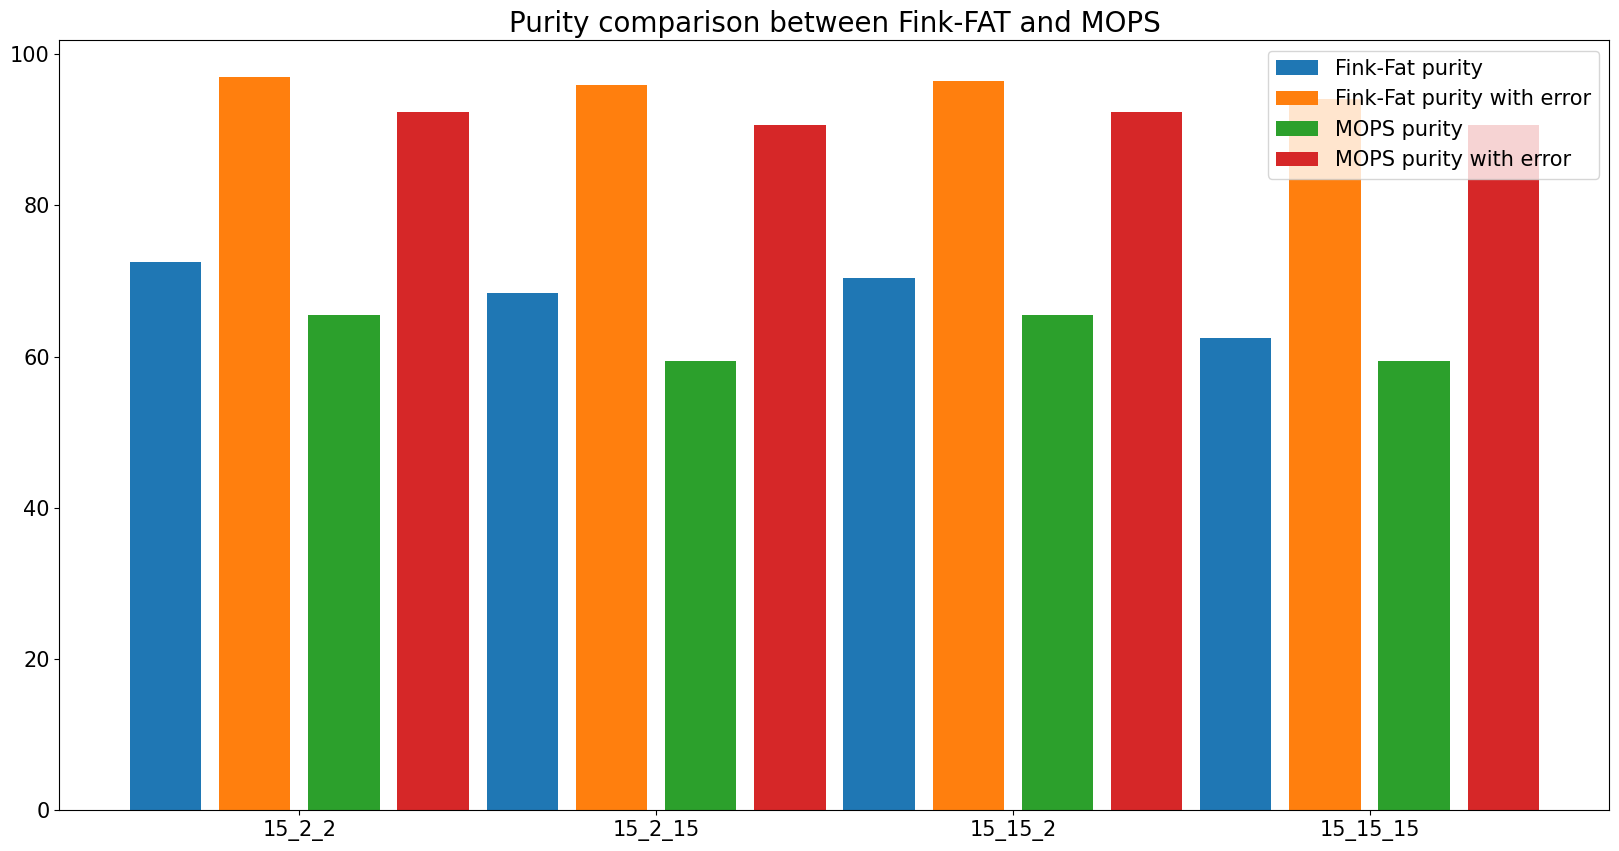

In [39]:
_ = plt.figure(figsize=(20, 10))
plt.title("Purity comparison between Fink-FAT and MOPS", fontdict={"size": 20})
plt.bar(np.arange(0, 4*4, 4), height=metrics_res["all"][0], label="Fink-Fat purity")
plt.bar(np.arange(1, 4*4, 4), height=metrics_res["all"][1], label="Fink-Fat purity with error")
plt.bar(np.arange(2, 4*4, 4), height=metrics_res["mops"][0], label="MOPS purity")
plt.bar(np.arange(3, 4*4, 4), height=metrics_res["mops"][1], label="MOPS purity with error")

plt.xticks([1.5, 5.5, 9.5, 13.5], ['15_2_2', '15_2_15', '15_15_2', '15_15_15'])
ax = plt.gca()
ax.tick_params(axis="x", which="major", labelsize=15)
ax.tick_params(axis="y", which="major", labelsize=15)
plt.legend(prop={"size": 15})
plt.show()

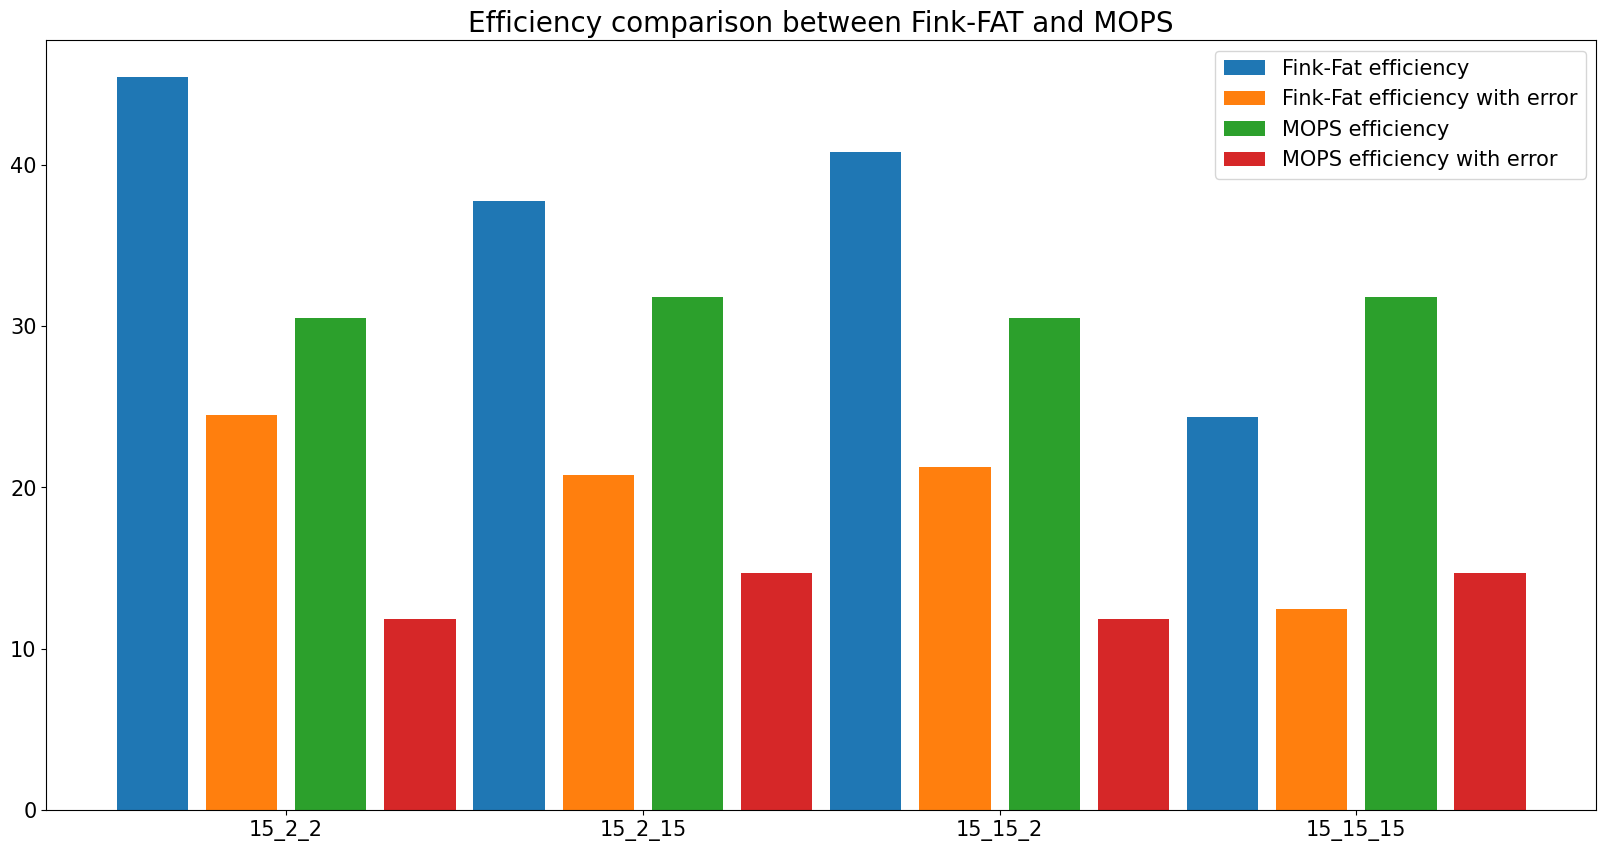

In [40]:
_ = plt.figure(figsize=(20, 10))
plt.title("Efficiency comparison between Fink-FAT and MOPS", fontdict={"size": 20})
plt.bar(np.arange(0, 4*4, 4), height=metrics_res["all"][2], label="Fink-Fat efficiency")
plt.bar(np.arange(1, 4*4, 4), height=metrics_res["all"][3], label="Fink-Fat efficiency with error")
plt.bar(np.arange(2, 4*4, 4), height=metrics_res["mops"][2], label="MOPS efficiency")
plt.bar(np.arange(3, 4*4, 4), height=metrics_res["mops"][3], label="MOPS efficiency with error")

plt.xticks([1.5, 5.5, 9.5, 13.5], ['15_2_2', '15_2_15', '15_15_2', '15_15_15'])
ax = plt.gca()
ax.tick_params(axis="x", which="major", labelsize=15)
ax.tick_params(axis="y", which="major", labelsize=15)
plt.legend(prop={"size": 15})
plt.show()

# Algorithm performance analysis

Machine configuration
* association
    * Single core algorithm
    * Intel Core Processor (Haswell, no TSX, IBRS)
    * CPU MHz:               2299.998
    * Memory RAM: 35.2 GB
* Orbit fitting
    * Distributed algorithm using Spark 3
    * 24 core with 4 core/executor (6 executors)
    * 8 GB of RAM/executors
    * Orbfit version: 5.0

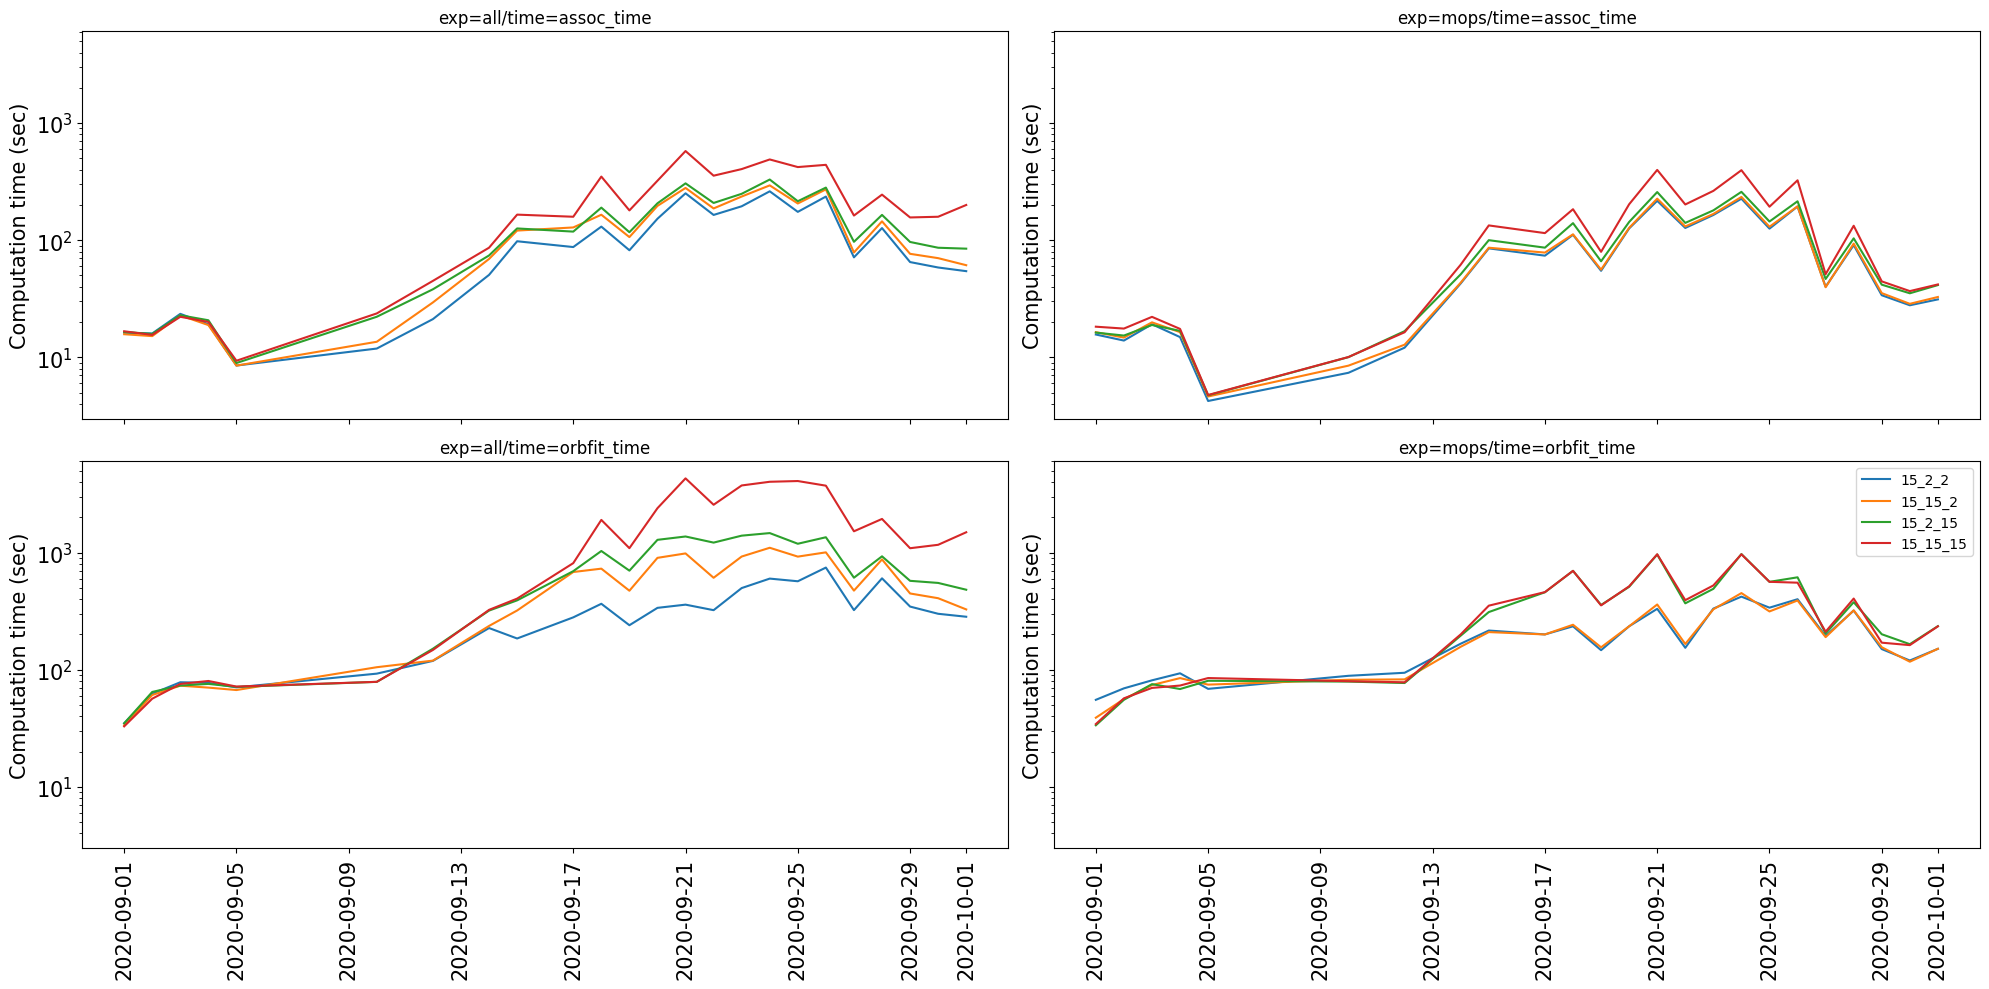

In [42]:
# _ = plt.figure(figsize=(20, 10))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10), sharey=True, sharex=True)

def time_plot(ax, kind_exp, time_col):
    ax.plot(u.get_stats("15_2_2", kind_exp).T[time_col], label="15_2_2")
    ax.plot(u.get_stats("15_15_2", kind_exp).T[time_col], label="15_15_2")
    ax.plot(u.get_stats("15_2_15", kind_exp).T[time_col], label="15_2_15")
    ax.plot(u.get_stats("15_15_15", kind_exp).T[time_col], label="15_15_15")
    ax.set_title("exp={}/time={}".format(kind_exp, time_col))
    ax.set_yscale('log')
    ax.tick_params(axis="x", which="major", labelsize=15, rotation=90)
    ax.tick_params(axis="y", which="major", labelsize=15)
    ax.set_ylabel("Computation time (sec)", fontsize=15)

time_plot(ax1, "all", "assoc_time")
time_plot(ax2, "mops", "assoc_time")
time_plot(ax3, "all", "orbfit_time")
time_plot(ax4, "mops", "orbfit_time")
plt.tight_layout()
plt.legend()
plt.show()

In [45]:
# 15_2_2 time analysis

all_stats = u.get_stats("15_2_2", "all").T
all_stats["api_time"] = u.get_api_time(u.path_tw, "15_2_2", "all_assoc")
mops_stats = u.get_stats("15_2_2", "mops").T
mops_stats["api_time"] = u.get_api_time(u.path_tw, "15_2_2", "mops")

In [46]:
all_stats

,assoc_time,nb_new_alerts,nb_old_obs,nb_orb,nb_traj,nb_traj_to_orbfit,orbfit_time,api_time
2020-09-01,16.221653,12420.0,0.0,3.0,0.0,7.0,34.867168,9.296275
2020-09-02,15.994779,11239.0,5769.0,22.0,3024.0,23.0,62.325501,7.890242
2020-09-03,23.511075,15988.0,9401.0,88.0,6343.0,92.0,78.083538,10.965699
2020-09-04,19.157688,14503.0,10587.0,202.0,15794.0,207.0,77.189257,9.958598
2020-09-05,8.513296,3314.0,11409.0,119.0,20016.0,124.0,70.601424,2.871762
2020-09-10,11.890733,4938.0,9661.0,361.0,19087.0,674.0,92.496940,3.735927
2020-09-12,21.206121,13938.0,1430.0,495.0,5173.0,1185.0,118.845680,9.754906
2020-09-14,50.601317,23141.0,5955.0,623.0,9311.0,2562.0,226.642502,16.015159
2020-09-15,97.984622,39106.0,7960.0,372.0,17867.0,2048.0,184.599933,43.330357
2020-09-17,87.444091,30846.0,14449.0,983.0,25654.0,3347.0,279.618585,21.117274


## Input data stats

In [48]:
gb_input_data = input_data.groupby("nid").count()
print("""
Number of alerts : {:,}
Per night : 
    * Median = {:,}
    * Min = {:,}
    * Max = {:,}
""".format(len(input_data), gb_input_data["ra"].median(), gb_input_data["ra"].min(), gb_input_data["ra"].max()))


Number of alerts : 796,486
Per night : 
    * Median = 26,993.5
    * Min = 3,314
    * Max = 69,831

